# NVT - From MD to Monte Carlo
\
It is presented the study of a system in the canonical ensamble, i.e. with temperature (as well as volume and number of particles) fixed. We are going to simulate the system in various thermodynamical conditions using the Metropolis algorithm, effectively sampling the relevant probability distribution:\
\
$$
P=\frac{e^{-E/(k_BT)}}{Z} 
$$

where $Z$ is the canonical partition function.\
\
The key difference is that now we are **not** going to try and **track** the evolution of the system in time as we did with MD, but rather we are going to generate configurations that agree with the statistical mechanics formulation of this model, and perform ensemble averages over those.\
The direct sampling of the Boltzmann distribution allows for a direct control of the temperature, the constancy of which is therefore most certainly not a result of some temperature-conserving integration algorithm

Autocorrelations are studied, and the results of some simulations are compared with MD ones\
\
The **parameters** corresponding to the three phases are chosen to be\
\
$\rho^\star = 1.1$, $T^\star = 0.8 \quad$ ($r_{cut} = 2.2$) for the solid phase\
$\rho^\star = 0.8$, $T^\star = 1.1 \quad$  ($r_{cut} = 2.5$) for the liquid phase\
$\rho^\star = 0.05$, $T^\star = 1.2 \quad$  ($r_{cut} = 5.0$) for the gas phase



In [1]:
from array import array
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [3]:
def read(observable, phase, instant=0, gofr=0, method='MC'):
    col = 1 if instant == 1 else 2
    lgt = 3 if gofr == 1 else 4
    observable = observable + method
    mat = []
    with open('NSL_SIMULATOR/OUTPUT/'+phase+'/'+observable+'.dat') as f:
            data = f.readlines()  
    for line in data:
        s = line.split()
        if s[0].replace('.', '', 1).isdigit(): #and len(s) == lgt:
            mat.append(s)
    if gofr == 1:
        distance = np.asarray(column(mat,0), dtype=np.float64)
        measure = np.asarray(column(mat,1), dtype=np.float64)
        errors = np.asarray(column(mat,2), dtype=np.float64)
        return distance, measure, errors
    else:
        measure = np.asarray(column(mat,col), dtype=np.float64)
        errors = np.asarray(column(mat,3), dtype=np.float64)
        return measure, errors

## Tail Corrections
Tail corrections for the evaluation of potential energy and pressure have been added to the code in order to make up for the cutoff imposed on the range of the Lennard-Jones potential. The cutoff still stands as in the fact that these corrections are extimated assuming that the radial distribution function of the system is close to $1$ outside the cutoff sphere. These are extimated as\
\
\
$$
\frac{\langle U \rangle _{tail}}{N}   = \frac{8\pi\rho}{9 r_c^9} - \frac{8\pi\rho}{3 r_c^3}
\qquad \qquad \frac{\langle W \rangle _{tail}}{3N}   = 32\pi\rho        \left[            \frac{1}{9 r_c^9}           - \frac{1}{6 r_c^3}        \right]
$$
\
in reduced units

## Autocorrelations

### Extimate of the block length
We define autocorrelation between data at different times as\
\
$$\chi(t)= \frac{\left<U(t')U(t'+t)\right>-\left<U(t')\right>\left<U(t'+t)\right>}{\sigma^{2}_{U}}$$
\
which is the same expression for connected correlators in Many Body theory and QFT (up to a normalization factor).\
\
The index $t'$ is a dummy variable, while $t$ represents the Monte Carlo step at which we are looking at the system\
\
Autocorrelations in our system are studied by analyzing the instantaneous (a single simulation is run, with $5\times 10^5$ blocks composed of one single step) values of the potential energy per particle, as it looks like the most suitable observable (along with pressure of course) for this purpose, since temperature (and therefore kinetic energy) is fixed.

In [4]:
def chi(m, t):
    span = len(m) - t
    m_shifted = m[t:]
    m_multiplied = m[:span] * m_shifted
    m_squared = m[:span] ** 2
    a0 = np.sum(m_multiplied)
    a1 = np.sum(m[:span])
    a2 = np.sum(m_shifted)
    a3 = np.sum(m_squared)
    a = np.array([a0, a1, a2, a3])
    a /= span
    return (a[0] - a[1] * a[2]) / (a[3] - a[1] * a[1])

In [5]:
phases = ['SOLID', 'LIQUID', 'GAS']
u = [np.zeros(300), np.zeros(300), np.zeros(300)]
autocor = [np.zeros(300), np.zeros(300), np.zeros(300)]

We show the results for the first 300 values of the correlation function in order to highlight the point where the function falls off

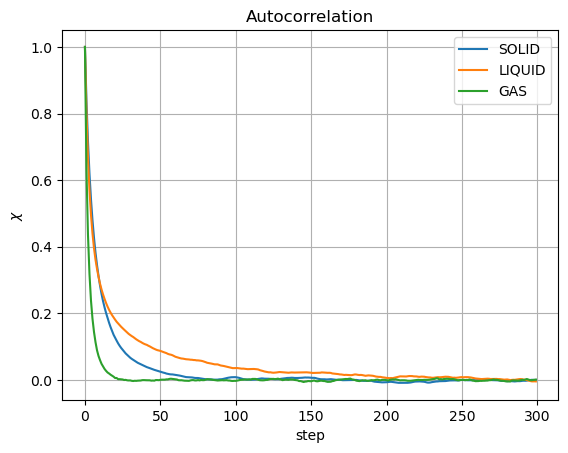

In [6]:
for i in range(len(phases)):
    u[i] = read('potential_energy_autocorr', phases[i], 1, 0, '')[0]
    for j in range(300):
        autocor[i][j] = chi(u[i], j)
    plt.plot(np.arange(300), autocor[i], label = phases[i])
plt.xlabel("step")
plt.ylabel("$\chi$")
plt.title("Autocorrelation", fontsize = 12)
plt.legend()
plt.grid()
plt.show()

From which it appears that autocorrelation needs about 25 steps to move from the dangerous heights of the start of the exponential, and 200 at most to approach its tail and be considered close to zero. This means that a sensible choice for the size of a block is 2000 steps, i.e. one order of magnitude above the time after which autocorrelation dies off

### Statistical Uncertainties

Statistical uncertainties are wildly underestimated when the size of the blocks is small: in order to compensate for that the right thing to do is considering blocks constituted by a number of steps that is larger than the autocorrelation time. In the following section the data for the instantaneous values of the potential energy is subdivided in blocks of length ranging from 10 to 5000. The sample means over these blocks are treated as the stochastic variables on which uncertainties are calculated with the usual formula for the dispersion of measurements

In [7]:
def error(av, av2, n):  
    if n == 0:
        return 0
    else:
        return math.sqrt((av2 - av**2)/n)

In [8]:
def uncertainty(err, L, m):  
    for i in L:
        mat = m.reshape(-1, i) #partiziona il vettore delle misurazioni in blocchi lunghi L
        stoch = np.mean(mat, axis=1)  #vettore delle variabili stocastiche
        stoch2 = stoch ** 2  #quadrato element-wise
        mean = np.mean(stoch)
        mean2 = np.mean(stoch2) #media dei quadrati
        err.append(error(mean, mean2, len(stoch))) #aggiunge l'incertezza calcolata per questa block size alla lista

In [9]:
M = 500000
L = [i for i in range(10, 5000+1) if M % i == 0]  #comprehension formata dai divisori del numero di misurazioni
errors = [[], [], []]

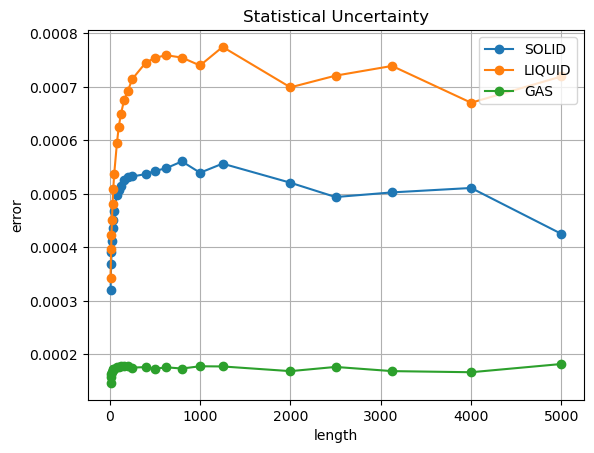

In [10]:
for i in range(len(phases)):
    uncertainty(errors[i], L, u[i])
    plt.plot(L, errors[i], marker='o', linestyle='-', label = phases[i])
    
plt.xlabel("length")
plt.ylabel("error")
plt.title("Statistical Uncertainty", fontsize = 12)
plt.legend()
plt.grid()
plt.show()

Uncertainty **saturates** to a value that is independent of the size of the block after the blocks reach sizes that are about that of the autocorrelation time (in MC steps), confirming that in order to give a sensible extimate for the statistical uncertainty of a sample, data blocking needs to be implemented keeping autocorrelation into account.\
\
Henceforth **simulations are run**, as per these results, with blocks (50) of 2000 steps

## Radial Distribution Function

We now turn to the study of a structural quantity, the radial distribution function. This function gives us some feeling of the spatial arrangement of the system as it is the probability of finding two particles at a distance $r$ relative to the one we would have if the particles were just randomly distributed. To compute we make use of a histogram based on the definition\
\
$$
g(r) =\frac{1}{\rho N\ Vol(r)} 
    \left\langle \sum_{}^N \sum_{i \neq j = 1}^N \delta(|r|-|\vec r_i-\vec r_j |) \right\rangle
$$
\
which is equivalent to marking a notch (two, actually) every time two particles are at a distance $r$. The factor $Vol(r)$ in the normalization accounts for discretization: it is the volume of the shell corresponding to the bin size.\
\
The histograms are made up of 100 bins.\
The values for the distance represented in the picture are obtained with a simple conversion from the bin number

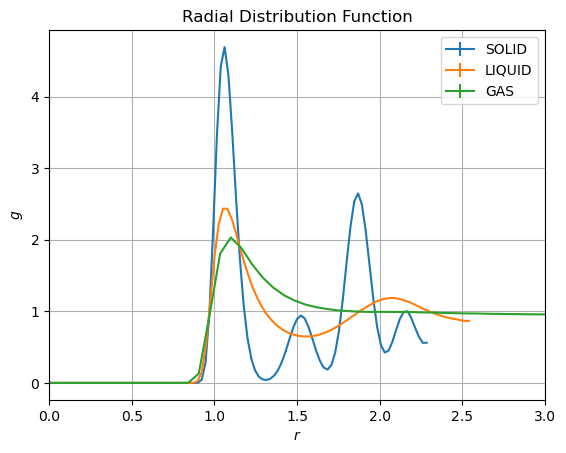

In [16]:
for i in range(len(phases)):
    g = read('gofr', phases[i], 0, 1)
    plt.errorbar(g[0], g[1], g[2], label = phases[i])
plt.xlabel("$r$")
plt.ylabel("$g$")
plt.title("Radial Distribution Function", fontsize = 12)
plt.legend()
plt.grid()
plt.xlim(0,3)
plt.show()

The presence of maxima for the solid and liquid phase reflects some kind of ordering (long-range and short-range respectively), which is absent in the gasseous phase. All three phases tough exhibit a peak corresponding to the minimum of the Lennard-Jones potential, and the fact that they are equal to zero for values smaller than that reflects the repulsive nature of the potential in that region

## Results

### NVT MC

We go on to illustrate the other results obtained for simulations performed, we recall, with\
**50** blocks composed of **2000** steps\
for other relevant thermodinamic observables, the potential energy per particle and pressure

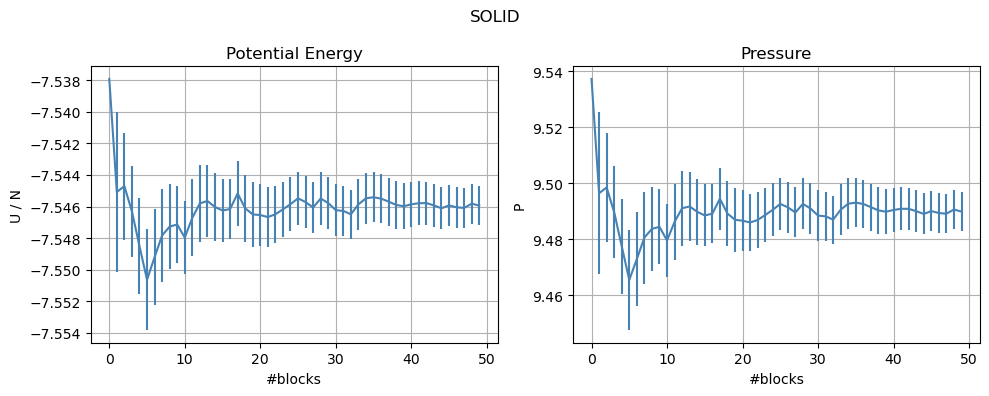

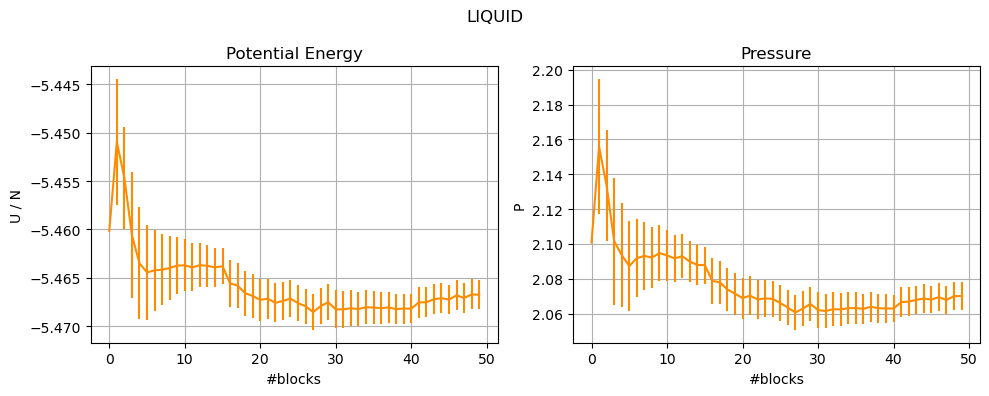

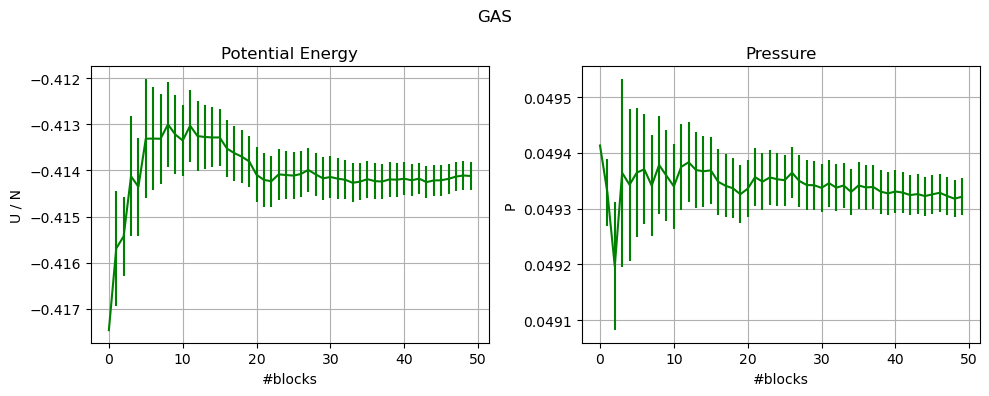

In [17]:
colors = ['steelblue', 'darkorange', 'green']
for i in range(len(phases)):
    U = read('potential_energy', phases[i], 0, 0)
    P = read('pressure', phases[i], 0, 0)
    fig = plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.errorbar(np.arange(len(U[0])), U[0], U[1], color=colors[i])
    plt.title('Potential Energy')
    plt.xlabel('#blocks')
    plt.ylabel('U / N')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.errorbar(np.arange(len(P[0])), P[0], P[1], color=colors[i])
    plt.title('Pressure')
    plt.xlabel('#blocks')
    plt.ylabel('P')
    plt.grid()
    
    fig.suptitle(phases[i])
    plt.tight_layout()
    plt.show()

### Comparison with NVE MD

Making use of the insight gained in the previous studies (namely, we know the starting temperatures for the phases we want to simulate), MD simulations in the **microcanonical** ensamble are run with the aim of comparing the structural properties in the two cases

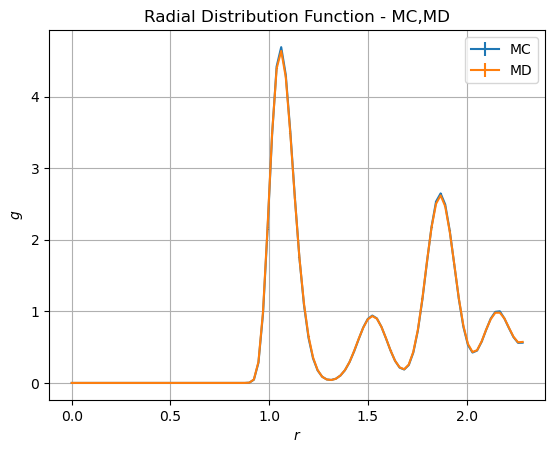

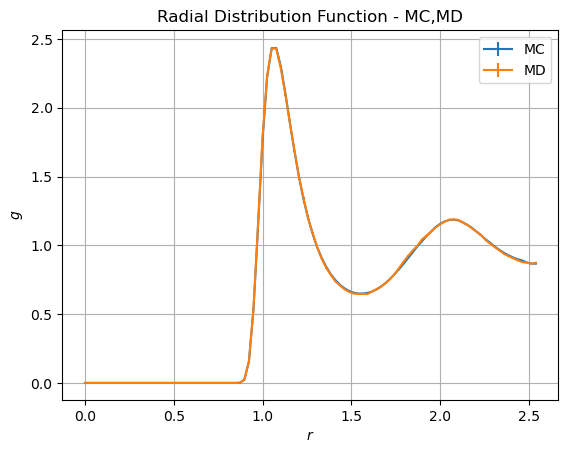

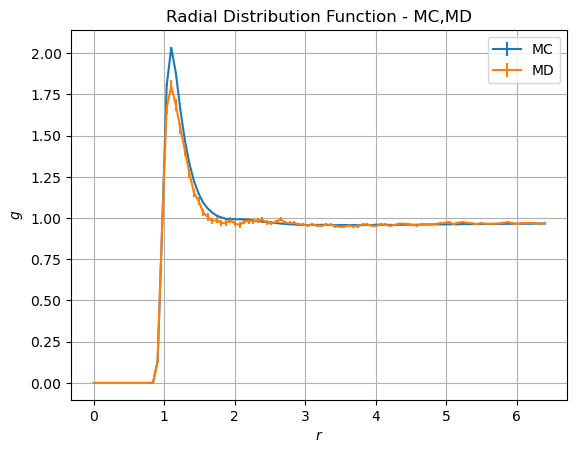

In [13]:
for i in range(len(phases)):
    mc = read('gofr', phases[i], 0, 1)
    md = read('gofr', phases[i], 0, 1, 'MD')
    
    plt.errorbar(mc[0], mc[1], mc[2], label ='MC')
    plt.errorbar(md[0], md[1], md[2], label ='MD')
    plt.title('Radial Distribution Function - MC,MD')
    plt.xlabel('$r$')
    plt.ylabel('$g$')
    plt.legend()
    plt.grid()
    
    fig.suptitle(phases[i])
    plt.show()

Which testifies to a pretty good agreement between the integration of Hamilton's equations and Monte Carlo methods